## Homework 4

Use this notebook as a starter

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [23]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-09-30 22:24:47--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K   978KB/s    in 0.2s    

2021-09-30 22:24:47 (978 KB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [24]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [25]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [26]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [27]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [28]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [29]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


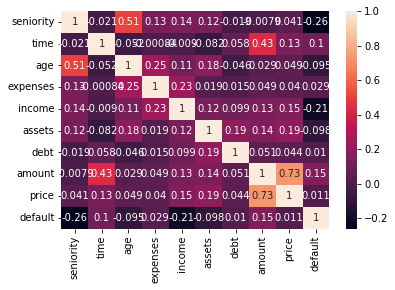

In [30]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(df.corr(), annot=True)
plt.show()

In [31]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [32]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
numerical_columns.remove('default')

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [35]:
from sklearn.metrics import roc_auc_score

In [36]:
max_score = 0
feature = ''
for f in df_train[numerical_columns].columns:
    score = roc_auc_score(y_train, df_train[f])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[f])
    print(f, score)
    if score < 1.0  and score > max_score:
        max_score = score
        feature = f
print(f'max score: {feature}, {max_score}')

seniority 0.7093778624491943
time 0.5608662489595051
age 0.5732933272499939
expenses 0.5009184217217011
income 0.682006666132633
assets 0.6486042567122802
debt 0.5047829675783548
amount 0.5910773431595518
price 0.5043329862114843
max score: seniority, 0.7093778624491943


Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Answer
The highest AUC belongs to seniority

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [37]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [38]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [39]:
val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred_probs = model.predict_proba(X_val)[:, 1]
'''
The following line is not needed
You calculate the AUC using the probabilities, not comparing the binary classifications.
'''
#y_pred = (y_pred_probs >= 0.5)

#y_pred_direct = model.predict(X_val)

print('AUC using probs: ', roc_auc_score(y_val, y_pred_probs).round(3))
#print('AUC with straight prediction: ', roc_auc_score(y_val, y_pred_direct).round(3))

AUC using probs:  0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

### Answer:

The AUC of this model is `0.812`

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [40]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred_probs >= t)
    predict_negative = (y_pred_probs < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, precision, recall))

/var/folders/z6/wchwkzy93yqb85l4qc39505r0000gn/T/ipykernel_63028/3391733898.py:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [41]:
score_columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=score_columns)

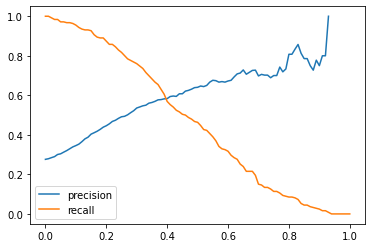

In [42]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

### Answer
Curves intersect at threshold 0.4

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [43]:
df_scores['f1'] = 2 * ( (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall) )

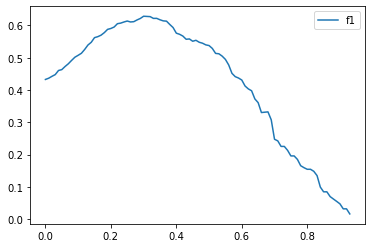

In [44]:
plt.plot(df_scores.threshold, df_scores.f1, label='f1')
plt.legend()

In [45]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
30,0.3,187,162,59,483,0.535817,0.760163,0.628571


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

### Answer

F1 is maximal at threshold `0.3`

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [46]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [47]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [48]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

kscores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['default'].values
    y_val = df_val['default'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    kscores.append(auc)

print(f'Mean: {np.mean(kscores)}, Standard deviation: {np.std(kscores)}')

Mean: 0.8141695497076604, Standard deviation: 0.01460989648482707


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

### Answer

The standard deviation is 0.14 across different folds

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [49]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    kscores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        f_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['default'].values
        y_val = df_val['default'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        kscores.append(auc)

    print(f'C: {C}, Mean: {np.mean(kscores).round(3)}, Standard deviation: {np.std(kscores).round(3)}')

 25%|██▌       | 1/4 [00:00<00:00,  4.33it/s]

C: 0.01, Mean: 0.809, Standard deviation: 0.013


 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

C: 0.1, Mean: 0.814, Standard deviation: 0.015


 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

C: 1, Mean: 0.814, Standard deviation: 0.015


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

C: 10, Mean: 0.814, Standard deviation: 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

### Answer

Best mean is `0.814` with STD of `0.015` for 3 different values of `C`. The smallest `C` for these values is `0.1`, so the answer is `C = 0.1`

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.